### End-to-End Retrieval & Grounded QA Pipeline on MS MARCO (BEIR)

This notebook implements a complete **retrieval-to-answering workflow** on the **MS MARCO (BEIR dev)** dataset, integrating sparse, dense, hybrid retrieval, reranking, and grounded answer generation with systematic evaluation.

#### Dataset & Setup
- Uses **BEIR MS MARCO (dev)** for retrieval benchmarking.
- Loads **original MS MARCO QA annotations** from HuggingFace for answer grounding.
- Supports **LOCAL / COLAB** execution with cached datasets and sharded encodings.

#### Retrieval Models
Three complementary retrieval paradigms are evaluated:

##### Lexical Retrieval (BM25)
- BM25 via **bm25s** with a BEIR-compatible wrapper.
- Hyperparameter tuning using **HalvingGridSearchCV** (`k1`, `b`, `delta`, `method`).
- Optimized directly on **NDCG@10** over dev subsamples.

##### Learned Sparse Retrieval (LSR)
- **SPLADE (rasyosef/splade-tiny)** for learned sparse representations.
- Sharded CSR matrices for scalable storage.
- GPU-based scoring with half-precision inference.

##### Learned Dense Retrieval (LDR)
- **BGE-M3 (BAAI/bge-m3)** dense encoder.
- Exact cosine similarity search over disk-backed embeddings.
- High-throughput GPU encoding with mixed precision.

#### Fusion & Reranking
- **Reciprocal Rank Fusion (RRF)** combines BM25, SPLADE, and Dense runs.
  - Weights and fusion parameter `k` tuned via **RandomizedSearchCV**.
- **Cross-Encoder Reranking** with `BAAI/bge-reranker-v2-m3`.
  - Applied to top-k fused candidates for final ranking.

#### Retrieval Evaluation
- Metrics computed with **confidence intervals**:
  - NDCG@{1, 3, 5, 10, 100, 1000}
  - MRR, MAP, Recall, Precision
- Comparative visualization across:
  - BM25 → LSR → LDR → RRF → Reranked

#### Query-Level Inspection
- Random query sampling for qualitative analysis.
- Displays:
  - Ground-truth passages
  - Retrieved top-k documents
  - Rank of the first relevant document
- Enables inspection of retrieval errors and strengths.

#### Grounded Answer Generation
- Uses **Qwen/Qwen3-0.6B** for answer generation.
- Answers are **strictly constrained to retrieved content**.
- Outputs *“I don’t know”* when evidence is insufficient.
- Batched generation with low-temperature decoding.

#### Answer-Level Evaluation
- Automatic metrics:
  - **BLEU**
  - **ROUGE-1 / ROUGE-2 / ROUGE-L / ROUGE-Lsum**
- LLM-based factuality grading:
  - Correct
  - Missing
  - Hallucinated
- Analysis includes:
  - Accuracy, missing rate, hallucination rate
  - ROC/AUC and optimal ROUGE thresholding
  - Correlation between lexical metrics and factual correctness

In [ ]:
!pip install IProgress faiss-gpu-cu12 numpy==1.26.4 evaluate absl-py rouge_score matplotlib scikit-learn bm25s torch beir dotenv openai "transformers==4.52.4" "huggingface_hub>=0.36.0" accelerate seaborn

In [ ]:
# "COLAB" or "LOCAL"
MACHINE_CONFIG = "LOCAL"

if MACHINE_CONFIG == "COLAB":
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install datasets bm25s beir IProgress
    
# Import all dependencies
import logging, os, sys, pathlib, random, json, pickle, joblib, gc
from typing import Dict, Any
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob
import numpy as np
import textwrap

# Plotting
import matplotlib.pyplot as plt

# Hyperparameter tuning using sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

# HuggingFace support
from datasets import load_dataset
import evaluate

# Import BM25 ranker
import bm25s

# Import PyTorch
import torch

# import BEIR framework
from beir.retrieval import models
from beir.reranking import Rerank
from beir import LoggingHandler, util
from beir.reranking.models import CrossEncoder
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

# Own eval module supporting CI's and variance estimation
if MACHINE_CONFIG == "COLAB":
    sys.path.append("/content/drive/MyDrive/BEIR_RESSOURCES")
from utils.custom_evaluation import EvaluateRetrievalCI
from utils.plot_metrics import plot_all_metrics_with_ci
from utils.openai_evaluator import evaluate_predictions_batch
from models.qwen import generate_chat_with_thinking, load_causal_lm
from models.rrf import RRFSklearnEstimator, weight_grid, reciprocal_rank_fusion
from models.qwen import load_causal_lm, batch_generate_chat_with_thinking

## MS MARCO Dataset

[https://microsoft.github.io/msmarco/](https://microsoft.github.io/msmarco/)

MS MARCO is a large-scale machine reading comprehension and retrieval dataset built from real Bing search queries. It includes over one million questions, human-generated answers, and nearly nine million passages extracted from web documents.

### Dataset Contents

* 1,010,916 questions
* 182,669 rewritten human answers
* 8,841,823 passages from 3,563,535 documents

### Tasks

1. Determine answerability and generate an answer from passages
2. Generate a well-formed standalone answer
3. Rank passages by relevance

MS MARCO’s scale and real-world query distribution make it a strong benchmark for information retrieval and QA research.

In [51]:
%%time

# Download msmarco.zip and unzip the dataset
dataset = "msmarco"
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"

if MACHINE_CONFIG == "COLAB":
    out_dir = "/content/drive/MyDrive/BEIR_RESSOURCES/datasets"
else:
    out_dir = os.path.join(pathlib.Path("BEIR").parent.absolute(), "data")

data_path = util.download_and_unzip(url, out_dir)

# Load the dataset for BEIR internally usage
type = "dev"
corpus, queries, qrels = GenericDataLoader(data_path).load(split=type)

100%|██████████| 8841823/8841823 [00:16<00:00, 531129.64it/s]


CPU times: user 17.3 s, sys: 1.96 s, total: 19.2 s
Wall time: 18.9 s


In [52]:
print(f"Dataset corpus contains {len(corpus)} documents (passages) and {len(queries)} queries")

Dataset corpus contains 8841823 documents (passages) and 6980 queries


### Loading the MS MARCO Dataset

BEIR provides only the retrieval-oriented MS MARCO version and does not include the answer annotations. To work with answers, the dataset must be loaded directly from the original MS MARCO source.

Important note:

* The **test split** cannot be used locally because its answers are hidden and evaluated only through the official **MS MARCO Leaderboard** server.

In [ ]:
%%time

# Load dataset from HuggingFace
if MACHINE_CONFIG == "COLAB":
    cache_dir = "/content/drive/MyDrive/BEIR_RESSOURCES/datasets/msmarco_v2.1"
else:
    cache_dir = "data/msmarco_v2.1"

ds = load_dataset(
    "microsoft/ms_marco",
    "v2.1",
    cache_dir=cache_dir,
)

# Convert to HF to expected dataset structure - dev is named validation in HF ds
hf_ds = ds["validation" if type=="dev" else type]

dataset = {}
for col in hf_ds.column_names:
    col_values = hf_ds[col]  # list
    dataset[col] = {i: v for i, v in enumerate(col_values)}

Assume that we have already run the entire notebook and stored all of the results in pickle files. Now, we are going to reload the results for further processing and analysis.

In [54]:
out_dir = Path("results_cache")

with open(out_dir / "results_bm25.pkl", "rb") as f:
    results_bm25 = pickle.load(f)
with open(out_dir / "results_lsr.pkl", "rb") as f:
    results_lsr = pickle.load(f)
with open(out_dir / "results_ldr.pkl", "rb") as f:
    results_ldr = pickle.load(f)
with open(out_dir / "results_rerank.pkl", "rb") as f:
    rerank_results = pickle.load(f)
with open(out_dir / "results_fused.pkl", "rb") as f:
    results_fused = pickle.load(f)

bm25_ndcg, bm25_map, bm25_recall, bm25_precision, bm25_mrr = EvaluateRetrievalCI.evaluate(qrels, results_bm25, k_values=[1, 3, 5, 10, 100, 1000])
lsr_ndcg, lsr_map, lsr_recall, lsr_precision, lsr_mrr = EvaluateRetrievalCI.evaluate(qrels, results_lsr, k_values=[1, 3, 5, 10, 100, 1000])
ldr_ndcg, ldr_map, ldr_recall, ldr_precision, ldr_mrr = EvaluateRetrievalCI.evaluate(qrels, results_ldr, k_values=[1, 3, 5, 10, 100, 1000])
fusion_ndcg, fusion_map, fusion_recall, fusion_precision, fusion_mrr = EvaluateRetrievalCI.evaluate(qrels, results_fused, k_values=[1, 3, 5, 10, 100, 1000])
rerank_ndcg, rerank_map, rerank_recall, rerank_precision, rerank_mrr = EvaluateRetrievalCI.evaluate(qrels, rerank_results, k_values=[1, 3, 5, 10, 100, 1000])

load_path = Path("results_cache/gen_eval_run.pkl")
with load_path.open("rb") as f:
    run = pickle.load(f)

pred_texts_ = run["pred_texts"]
gen_outputs_ = run["gen_outputs"]
agg_ = run["agg"]
bleu_results_ = run["bleu"]
rouge_results_ = run["rouge"]
config_ = run["config"]
eval_results_ = run["eval_results"]
refs_ = run["refs"]

### BEIR-Compatible model wrapper

* **BM25sSearch:** BEIR-Compatible BM25 Wrapper

  * `BM25sSearch` adapts the `bm25s` lexical retriever to the BEIR interface. It constructs a BM25 index from `title + text`, preserves a stable mapping between BM25 internal indices and BEIR document IDs, and outputs BEIR-formatted retrieval results.

  * **Functionality:**

    * Tokenizes and indexes the corpus using `bm25s`.
    * Retrieves top-ranked document indices via `retrieve()`.
    * Maps bm25 indices back to BEIR document IDs.
    * Produces `results[qid][doc_id] = score` in the BEIR format.


In [55]:
from models.bm25_wrapper import BM25sSearch

* **SPLADE / SparseSearchHF:** BEIR-Compatible Learned Sparse Retrieval (LSR)

  * Provides SPLADE encoding and sparse retrieval without importing or patching BEIR. `LocalSPLADE` produces sparse CSR term-weight vectors from HF MLM models; `SparseSearchHF` performs BEIR-format retrieval over these embeddings.

  * **Functionality:**

    * Extracts `title + text` and computes SPLADE sparse embeddings locally.
    * Scores queries against the sparse corpus matrix (in-memory or shard-based).
    * Maintains stable mapping between matrix columns and BEIR document IDs.
    * Produces BEIR-formatted results: `results[qid][doc_id] = score`.

In [56]:
from models.hf_sparse_wrapper import LSR, SparseSearchHF

### BM25sEstimator: Sklearn-Compatible Wrapper

`BM25sEstimator` provides an sklearn-style interface for BM25s so it can be tuned with tools like `GridSearchCV`.

**fit()**
Builds a `BM25sSearch` instance from `corpus`, `queries`, and `qrels`, and wraps it with `EvaluateRetrievalCI` for BEIR-style evaluation.

**score()**
Runs retrieval and returns mean NDCG@k_eval as the single scalar metric required by sklearn.

**Purpose**
Enables hyperparameter search for BM25 (`k1`, `b`, `delta`, `method`) within standard sklearn workflows while still using BEIR evaluation metrics.

In [57]:
from models.bm25_wrapper import BM25sEstimator

### Subsampling the Dataset for Faster Prototyping

This cell defines a helper function that creates a smaller BEIR/MS MARCO subset for quick experimentation.
The function:

* randomly selects a specified number of queries (`num_golds`)
* retrieves their corresponding gold documents
* samples additional noise documents without scanning the full corpus
* returns a reduced `corpus`, `queries`, and `qrels` containing only the selected items

In [8]:
# Precompute once (outside the function)
ALL_QIDS = list(qrels.keys())
CORPUS_IDS = list(corpus.keys())
N_CORPUS = len(CORPUS_IDS)

def subsample_dataset(corpus, queries, qrels, num_golds=10, num_noise=100, seed=None,
                      all_qids=None, corpus_ids=None):
    rng = random.Random(seed)  # seed=None -> different each call

    if all_qids is None:
        all_qids = list(qrels.keys())
    if corpus_ids is None:
        corpus_ids = list(corpus.keys())
    n_corpus = len(corpus_ids)

    if num_golds > len(all_qids):
        raise ValueError("num_golds exceeds available queries")

    # 1) sample query ids
    keep_qids = rng.sample(all_qids, num_golds)

    # 2) collect their gold doc ids (dev split: one per query)
    gold_doc_ids = {next(iter(qrels[qid])) for qid in keep_qids}

    # 3) sample noise without scanning the whole corpus
    noise_doc_ids = set()
    need = min(num_noise, n_corpus - len(gold_doc_ids))
    while len(noise_doc_ids) < need:
        doc_id = corpus_ids[rng.randrange(n_corpus)]
        if doc_id not in gold_doc_ids:
            noise_doc_ids.add(doc_id)

    kept_doc_ids = gold_doc_ids | noise_doc_ids

    corpus_sub = {doc_id: corpus[doc_id] for doc_id in kept_doc_ids}
    queries_sub = {qid: queries[qid] for qid in keep_qids}
    qrels_sub = {qid: qrels[qid] for qid in keep_qids}

    return corpus_sub, queries_sub, qrels_sub

# Example:
# Take a subset of the actual dataset
# subs_corpus, subs_queries, subs_qrels = subsample_dataset(
#     corpus, queries, qrels, 
#     num_golds=int(len(qrels)*0.01), 
#     num_noise=int(len(corpus)*0.01), 
#     seed=1234)

# print(f"Corpus of {len(corpus)} was subsampled down to {len(subs_corpus)} samples.")

In [ ]:
# For demo only - please dont run this cell for trainig the models in a productive scenario!
c = corpus
corpus, queries, qrels = subsample_dataset(
    corpus, queries, qrels, 
    num_golds=int(len(qrels)*0.02), 
    num_noise=int(len(corpus)*0.005), 
    seed=1234)
print(f"Corpus of {len(c)} was subsampled down to {len(corpus)} samples.")
del c

### Hyperparameter Search with HalvingGridSearchCV on Subsampled Data

This cell sets up and runs a successive halving grid search to tune BM25 parameters (`k1`, `b`, `delta`, `method`) using the sklearn-compatible `BM25sEstimator`.

A small set of subsampled datasets is generated for efficiency.
Each subsample contains a fraction of queries (gold examples) and randomly sampled noise documents, enabling much faster evaluation.

`HalvingGridSearchCV` then progressively allocates more subsamples to the best-performing parameter configurations, optimizing for mean NDCG@10.
The best estimator is stored in `search.best_estimator_`, and can be used directly for retrieval through its underlying BM25 model.

The original dataset ratio would be defined by
* `num_golds = int(len(qrels)*1)`
* `num_noise = int(len(corpus)*1)`.

However, decreasing the golds in regards of increased noise would make it even harder. Like:
* `num_golds = int(len(qrels)*0.2)`
* `num_noise = int(len(corpus)*0.4)`.

Take note: We tune BM25 hyperparameters on the test set!

In [11]:
search = None

In [ ]:
data_dict = {
    "corpus": corpus,
    "queries": queries,
    "qrels": qrels,
}

est = BM25sEstimator(k_eval=10)

param_grid = {
    "k1":   [0.9, 1.2, 1.5, 1.8],
    "b":    [0.3, 0.5, 0.75, 0.9],
    "delta":[0.0, 0.5, 1.0],
    "method": ["bm25+", "bm25l", "lucene", "robertson"],
}

# Build N subsamples
subs = []
for seed in range(5):
    c_sub, q_sub, qr_sub = subsample_dataset(
        corpus, queries, qrels,
        num_golds=int(len(qrels)*0.2),
        num_noise=int(len(corpus)*0.4),
        seed=seed,
    )
    subs.append({"corpus": c_sub, "queries": q_sub, "qrels": qr_sub})

idx = np.arange(len(subs))
cv = [(idx, idx)]
max_resources = len(subs)

# We don't separate train/test in CV; dev subsamples are used directly for hyperparameter selection.
search = HalvingGridSearchCV(
    BM25sEstimator(k_eval=10),
    param_grid=param_grid,
    cv=cv,
    resource="n_samples",
    min_resources=1,
    max_resources=max_resources,
    factor=3,
    n_jobs=3,
    refit=True,
)
search.fit(subs)

print("Best params:", search.best_params_)
print("Best NDCG@10:", search.best_score_)

best_bm25 = search.best_estimator_


Found:
* Best params: {'b': 0.5, 'delta': 0.0, 'k1': 0.9, 'method': 'robertson'}

### Running BM25sSearch with Tuned Parameters

This block instantiates a `BM25sSearch` model using the best hyperparameters found through cross-validation.
The model is wrapped with `EvaluateRetrievalCI` to enable BEIR-style evaluation, after which sparse retrieval results are computed for all queries.

In [ ]:
%%time

# Retain the optimal values from prior run if no optimization run was done now
if search:
    model = BM25sSearch(corpus, **search.best_params_)
else:
    model = BM25sSearch(corpus, k1=0.9, b=0.5, delta=0.0, method='robertson')

retriever = EvaluateRetrievalCI(model)
results_bm25 = retriever.retrieve(corpus, queries)

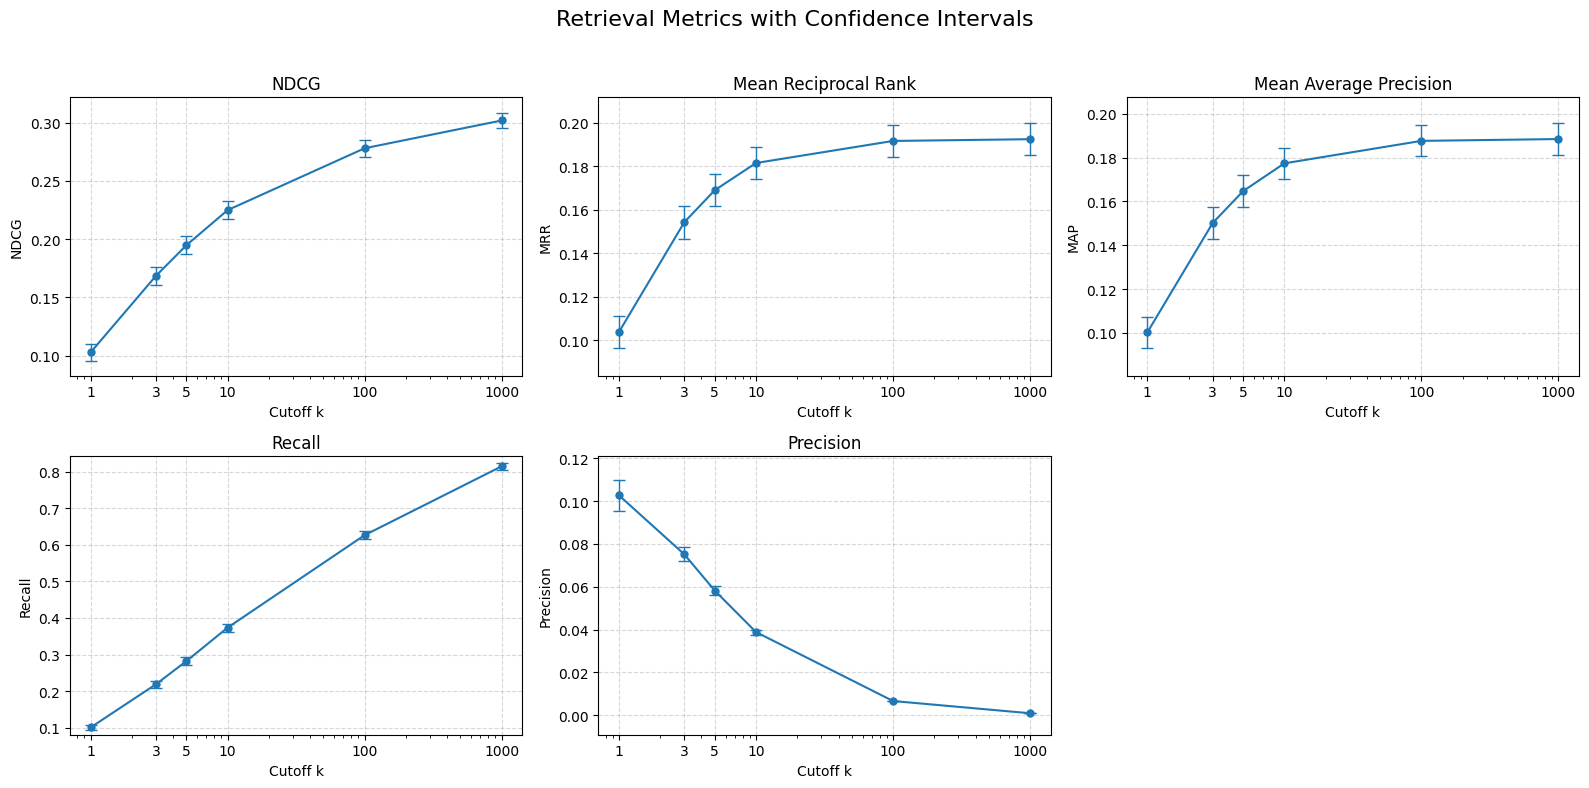

In [58]:
bm25_ndcg, bm25_map, bm25_recall, bm25_precision, bm25_mrr = EvaluateRetrievalCI.evaluate(qrels, results_bm25, k_values=[1, 3, 5, 10, 100, 1000])

plot_all_metrics_with_ci(
    metrics={
        "NDCG": bm25_ndcg,
        "MRR": bm25_mrr,
        "MAP": bm25_map,
        "Recall": bm25_recall,
        "Precision": bm25_precision,
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
)

In [59]:
print(bm25_ndcg, bm25_map, bm25_recall, bm25_precision, bm25_mrr)

{'NDCG@1': {'mean': 0.10272206303724929, 'var': 0.09218344760027113, 'ci': (0.09559919606853225, 0.10984493000596633)}, 'NDCG@3': {'mean': 0.1685399935428926, 'var': 0.11015684645800365, 'ci': (0.16075364021234573, 0.17632634687343945)}, 'NDCG@5': {'mean': 0.19478473265692747, 'var': 0.11151256052754557, 'ci': (0.18695061203492108, 0.20261885327893386)}, 'NDCG@10': {'mean': 0.2249678824279253, 'var': 0.1090327106310728, 'ci': (0.21722136032114966, 0.2327144045347009)}, 'NDCG@100': {'mean': 0.2781057162012479, 'var': 0.09416626994037935, 'ci': (0.2709066520448302, 0.2853047803576656)}, 'NDCG@1000': {'mean': 0.30196110050731667, 'var': 0.0836390573729302, 'ci': (0.29517636495573846, 0.3087458360588949)}} {'MAP@1': {'mean': 0.10016714422158547, 'var': 0.0889485638659737, 'ci': (0.09317037047726887, 0.10716391796590208)}, 'MAP@3': {'mean': 0.15019500159184973, 'var': 0.09846654779342348, 'ci': (0.14283339311475124, 0.15755661006894822)}, 'MAP@5': {'mean': 0.16474968163005413, 'var': 0.0973

### Running SparseSearchHF

This block instantiates a `LSR` model.
The model is wrapped with `SparseSearchHF` and `EvaluateRetrievalCI` to enable BEIR-style evaluation, after which sparse retrieval results are computed for all queries.

It encodes the corpus and queries with the SPLADE sparse retriever and writes the corpus encodings to `encode_output_path` as multiple shard files (pattern `corpus.*.npz`), using `shard_size` documents per shard. If `overwrite=True`, existing shard files are replaced; `query_weights=True` stores weighted query representations and `show_progress=True` enables progress bars.

In [ ]:
%%time

model = LSR("rasyosef/splade-tiny",max_length=256)
sparse_model = SparseSearchHF(model, batch_size=16)

retriever =  EvaluateRetrievalCI(sparse_model)

# Encodes into several shards and loads them again to evaluate (must be doen in the initial run)
results = sparse_model.encode(
    corpus,
    queries,
    encode_output_path="shards",
    corpus_filename="corpus.*.npz",
    shard_size=10000,
    overwrite=True,
    query_weights=True,
    show_progress=True,
)

Since `encode_and_retrieve` will take several hours, we pre-computed the sparse matrix already and stored it into several shards locally. Now we load the saved SPLADE encodings from disk: `query_file` points to the serialized query representations (`queries.pkl`), and `corpus_files` gathers all sharded corpus matrices matching `corpus.*.npz` (sorted to keep a consistent shard order).

In [15]:
query_file = os.path.join(pathlib.Path("BEIR").parent.absolute(), "shards") + "/queries.pkl"
corpus_files = sorted(glob(os.path.join(pathlib.Path("BEIR").parent.absolute(), "shards") + "/corpus.*.npz"))

Load the saved query embeddings from `query_file` and search across all corpus shards in `corpus_files`, returning the top-`1000` documents per query.

* **Compute:** GPU scoring (`device="cuda"`) in half precision (`dtype="float16"`)
* **Batching:** `query_batch_size` queries per batch, `shard_batch_size` shards per batch
* **Merging:** `merge_shard_batch=True` merges partial rankings after each shard batch
* **UI:** `show_progress=True` shows progress bars

In [ ]:
%%time

model = LSR("rasyosef/splade-tiny",max_length=256)
sparse_model = SparseSearchHF(model, batch_size=64)

results_lsr = sparse_model.search_from_files(
    query_embeddings_file=query_file,
    corpus_embeddings_files=corpus_files,
    top_k=1000,
    device="cuda",
    shard_batch_size=10, # 10 := Would utilize ~7.5GB VRAM on NVIDIA GeForce RTX 4070 (depends on the shard size configured prior)
    merge_shard_batch=True,
    query_batch_size=len(queries),
    dtype="float16",
    show_progress=True,
)

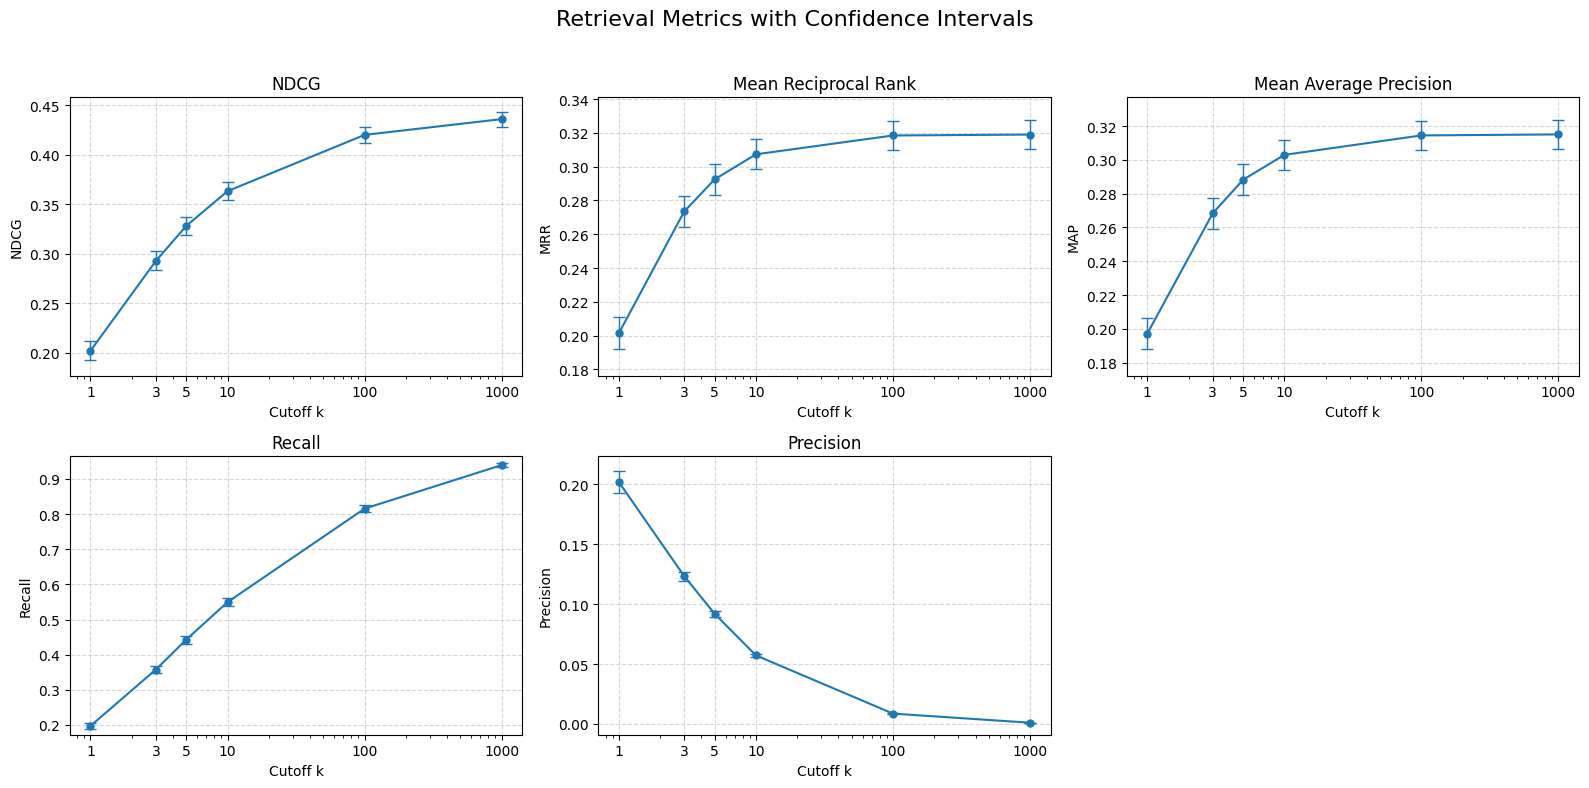

In [60]:
lsr_ndcg, lsr_map, lsr_recall, lsr_precision, lsr_mrr = EvaluateRetrievalCI.evaluate(qrels, results_lsr, k_values=[1, 3, 5, 10, 100, 1000])

plot_all_metrics_with_ci(
    metrics={
        "NDCG": lsr_ndcg,
        "MRR": lsr_mrr,
        "MAP": lsr_map,
        "Recall": lsr_recall,
        "Precision": lsr_precision,
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
)

In [61]:
print(lsr_ndcg, lsr_map, lsr_recall, lsr_precision, lsr_mrr)

{'NDCG@1': {'mean': 0.20186246418338108, 'var': 0.16113709528093081, 'ci': (0.1924451702611215, 0.21127975810564065)}, 'NDCG@3': {'mean': 0.29271048619162143, 'var': 0.16648938994663198, 'ci': (0.2831380684941019, 0.302282903889141)}, 'NDCG@5': {'mean': 0.32806444583614675, 'var': 0.15983821876679333, 'ci': (0.3186851836629663, 0.3374437080093272)}, 'NDCG@10': {'mean': 0.3632099367501316, 'var': 0.14722548061175877, 'ci': (0.3542083338499048, 0.37221153965035836)}, 'NDCG@100': {'mean': 0.42009960039983085, 'var': 0.11597012358172047, 'ci': (0.4121104348607868, 0.4280887659388749)}, 'NDCG@1000': {'mean': 0.43603279382095766, 'var': 0.10473255313004069, 'ci': (0.4284405664569142, 0.44362502118500113)}} {'MAP@1': {'mean': 0.19724212034383953, 'var': 0.15626776675024395, 'ci': (0.18796820637311756, 0.2065160343145615)}, 'MAP@3': {'mean': 0.26835402737981534, 'var': 0.15619860508842168, 'ci': (0.25908216588062727, 0.2776258888790034)}, 'MAP@5': {'mean': 0.28824418974848776, 'var': 0.1503763

### Running DenseRetrieval

This block instantiates a dense retrieval model using a HuggingFace encoder.
The model is wrapped with `DenseRetrievalExactSearch (DRES)` and `EvaluateRetrieval` to enable BEIR-style dense retrieval and evaluation using cosine similarity.

It encodes the corpus and queries with a dense bi-encoder (`BAAI/bge-m3`) and writes the resulting embeddings to `encode_output_path` as multiple shard files (pattern `corpus.*.pkl`). The encoding is performed in batches, with `batch_size` controlling throughput and `corpus_chunk_size` determining how many documents are processed per chunk to manage memory usage.

Mixed-precision (`float16`) is used for faster inference, and `convert_to_tensor=False` allows GPU memory to be freed between batches. If `overwrite=False`, existing embedding files are preserved and encoding is skipped for already-encoded shards.


In [19]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True

model = DRES(
    models.HuggingFace(
        model_path="BAAI/bge-m3",
        torch_dtype=torch.float16,
        max_length=256,
        prompts={"query": "", "passage": ""},
    ),
    batch_size=80,              # push up until stable
    corpus_chunk_size=1000000,     # optional; adjust to fit mem
    convert_to_tensor=False,      # free GPU between batches
)
retriever = EvaluateRetrieval(model, score_function="cos_sim")

encode_dir = "embeddings_bge_m3"

In [ ]:
%%time

# Encode and save
model.encode(
    corpus,
    queries,
    encode_output_path=encode_dir,
    corpus_filename="corpus.*.pkl",
    overwrite=False,
)

### Running Dense Retrieval Search

This block performs dense retrieval over pre-encoded embeddings stored on disk.
It loads the query embeddings from `queries.pkl` and iterates over multiple corpus embedding shard files (`corpus.*.pkl`) to compute similarity scores using cosine similarity.

The search is executed via `search_from_files`, which avoids loading the full corpus into memory at once and instead processes each shard sequentially. For each query, the top `k` (here, 1000) most similar documents are retrieved across all shards, and the final ranked results are aggregated into a single results dictionary.

In [ ]:
%%time

corpus_files = sorted(Path(encode_dir).glob("corpus.*.pkl"))
results_ldr = model.search_from_files(
    query_embeddings_file=f"{encode_dir}/queries.pkl",
    corpus_embeddings_files=corpus_files,
    top_k=1000,
    score_function="cos_sim",
)

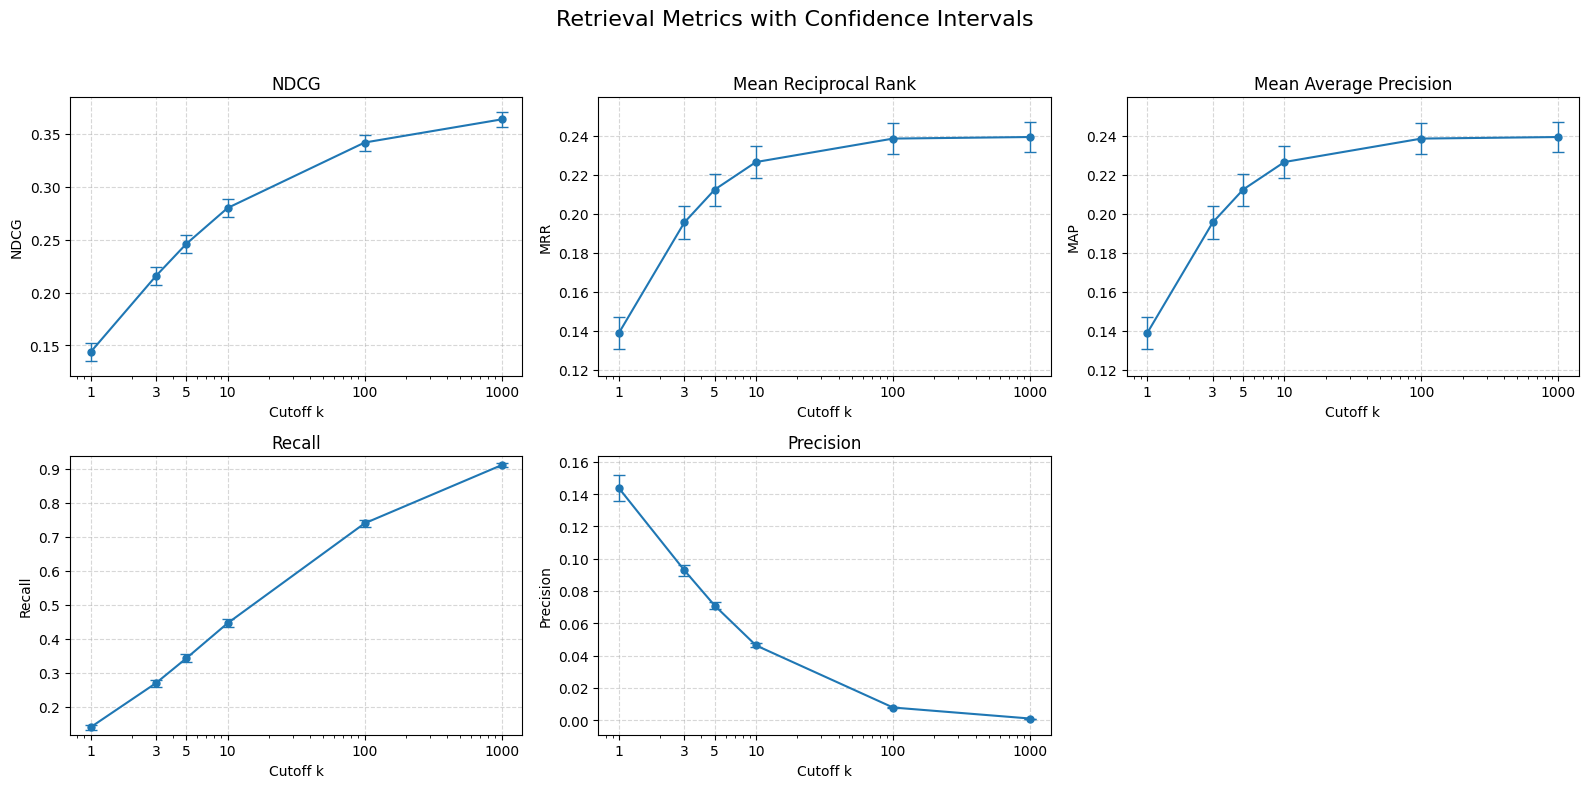

In [62]:
ldr_ndcg, ldr_map, ldr_recall, ldr_precision, ldr_mrr = EvaluateRetrievalCI.evaluate(qrels, results_ldr, k_values=[1, 3, 5, 10, 100, 1000])

plot_all_metrics_with_ci(
    metrics={
        "NDCG": ldr_ndcg,
        "MRR": ldr_map,
        "MAP": ldr_map,
        "Recall": ldr_recall,
        "Precision": ldr_precision,
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
)

In [63]:
print(ldr_ndcg, ldr_map, ldr_recall, ldr_precision, ldr_mrr)

{'NDCG@1': {'mean': 0.14369627507163324, 'var': 0.12306528673207504, 'ci': (0.13546634502087385, 0.15192620512239263)}, 'NDCG@3': {'mean': 0.21563162637396935, 'var': 0.13597789160339277, 'ci': (0.20698070207812475, 0.22428255066981395)}, 'NDCG@5': {'mean': 0.24600412546597838, 'var': 0.1346247046328127, 'ci': (0.23739635372840528, 0.2546118972035515)}, 'NDCG@10': {'mean': 0.27986559321930515, 'var': 0.12815362702013758, 'ci': (0.2714672462885613, 0.288263940150049)}, 'NDCG@100': {'mean': 0.3416811923923699, 'var': 0.1038454562191718, 'ci': (0.33412118692880655, 0.3492411978559332)}, 'NDCG@1000': {'mean': 0.36355636338424324, 'var': 0.0916272491554011, 'ci': (0.35645501720697337, 0.3706577095615131)}} {'MAP@1': {'mean': 0.13902817574021015, 'var': 0.11758410421946698, 'ci': (0.13098360884340113, 0.14707274263701917)}, 'MAP@3': {'mean': 0.19563037249283668, 'var': 0.12465209532520588, 'ci': (0.18734755386380414, 0.20391319112186923)}, 'MAP@5': {'mean': 0.21250477554918815, 'var': 0.1218

### Running Reciprocal Rank Fusion (RRF) with Hyperparameter Search

This block performs score fusion over multiple retrieval runs using Reciprocal Rank Fusion (RRF).
The input `runs` list contains retrieval results from different systems (e.g., BM25, sparse, and dense retrievers), which are combined and evaluated against the provided relevance judgments (`qrels`).

A grid of candidate weight vectors is generated to control the relative contribution of each run in the fusion process, along with different values of the RRF parameter `k`. These parameters are explored using `RandomizedSearchCV`, treating the fusion process as a scikit-learn–compatible estimator.

A single dummy cross-validation split is used since the evaluation is deterministic and does not require data partitioning. For each sampled configuration, the fused rankings are evaluated using NDCG@10, and the best-performing parameter combination is selected.

In [ ]:
runs = [results_bm25, results_lsr, results_ldr]

# Build a list of weight vectors and sample from it
all_weights = weight_grid(num_runs=len(runs), start=0.1, end=1.0, step=0.1)
param_distributions = {
    "k": [20, 60, 120],
    "weights": all_weights,
}

cv_single = [(np.array([0]), np.array([0]))]

search = RandomizedSearchCV(
    estimator=RRFSklearnEstimator(k_eval=10, top_k=10, show_progress=True),
    param_distributions=param_distributions,
    n_iter=100,
    cv=cv_single,
    n_jobs=10,
    verbose=2,
    random_state=42,
)

with joblib.parallel_backend("threading"):
    search.fit([{"runs": runs, "qrels": qrels}])

print("Best NDCG@10:", search.best_score_)
print("Best params:", search.best_params_)


In [7]:
search.best_params_

{'weights': [0.3, 1.0, 0.7], 'k': 20}

* Best NDCG@10: 0.39349170902295794
* Best params: {'weights': [0.3, 1.0, 0.7], 'k': 20}

### Running Final Reciprocal Rank Fusion

This block fuses multiple retrieval runs (BM25, sparse, dense) using Reciprocal Rank Fusion (RRF).
Each run is weighted to control its contribution, and the `k` parameter determines rank smoothing. The fused rankings are truncated to the top 1000 documents per query and returned for evaluation or reranking.

In [25]:
results_fused = reciprocal_rank_fusion(
    [results_bm25, results_lsr, results_ldr],
    weights=[0.3, 1.0, 0.7],
    k=20,
    top_k=1000
)

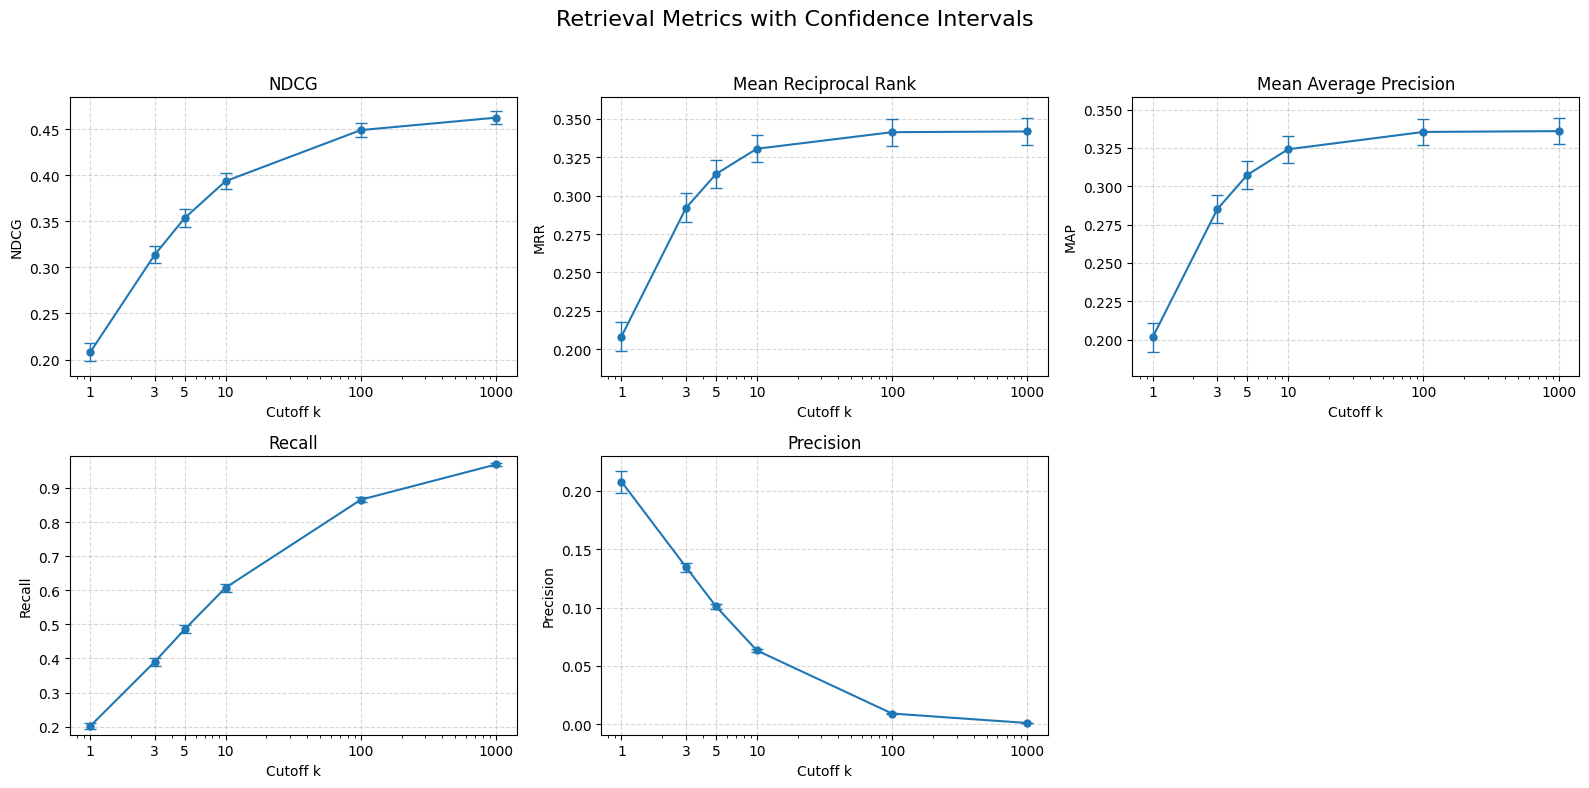

In [64]:
fusion_ndcg, fusion_map, fusion_recall, fusion_precision, fusion_mrr = EvaluateRetrievalCI.evaluate(qrels, results_fused, k_values=[1, 3, 5, 10, 100, 1000])

plot_all_metrics_with_ci(
    metrics={
        "NDCG": fusion_ndcg,
        "MRR": fusion_mrr,
        "MAP": fusion_map,
        "Recall": fusion_recall,
        "Precision": fusion_precision,
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
)

In [65]:
print(fusion_ndcg, fusion_map, fusion_recall, fusion_precision, fusion_mrr)

{'NDCG@1': {'mean': 0.20787965616045845, 'var': 0.16468929917053662, 'ci': (0.19835912780705214, 0.21740018451386475)}, 'NDCG@3': {'mean': 0.3137912827327606, 'var': 0.1674162373529988, 'ci': (0.3041922571627714, 0.3233903083027498)}, 'NDCG@5': {'mean': 0.35360414597094353, 'var': 0.1578917857897879, 'ci': (0.3442821667957061, 0.36292612514618094)}, 'NDCG@10': {'mean': 0.3934917090229579, 'var': 0.14169711102714913, 'ci': (0.38466072990262434, 0.4023226881432914)}, 'NDCG@100': {'mean': 0.4489528923120345, 'var': 0.10826344760809747, 'ci': (0.44123374575667224, 0.45667203886739677)}, 'NDCG@1000': {'mean': 0.4624283677708822, 'var': 0.09808961547164806, 'ci': (0.4550808630115423, 0.46977587253022207)}} {'MAP@1': {'mean': 0.20156399235912129, 'var': 0.15805048220456155, 'ci': (0.19223732961808881, 0.21089065510015376)}, 'MAP@3': {'mean': 0.28502865329512894, 'var': 0.15621914249948538, 'ci': (0.27575618227138077, 0.2943011243188771)}, 'MAP@5': {'mean': 0.30741045845272214, 'var': 0.148741

### Running Cross-Encoder Reranking

This block applies a cross-encoder reranker to refine the fused retrieval results.
A pretrained cross-encoder model (`BAAI/bge-reranker-v2-m3`) scores query–document pairs jointly, providing more accurate relevance estimates than bi-encoder retrieval.

The reranker processes the top candidates from the fused results in large batches and reorders them based on cross-encoder scores. The final output contains the top 100 reranked documents per query.

In [ ]:
%%time

model = CrossEncoder("BAAI/bge-reranker-v2-m3", max_length=256)
reranker = Rerank(model, batch_size=10)

rerank_results = reranker.rerank(corpus, queries, results_fused, top_k=100)

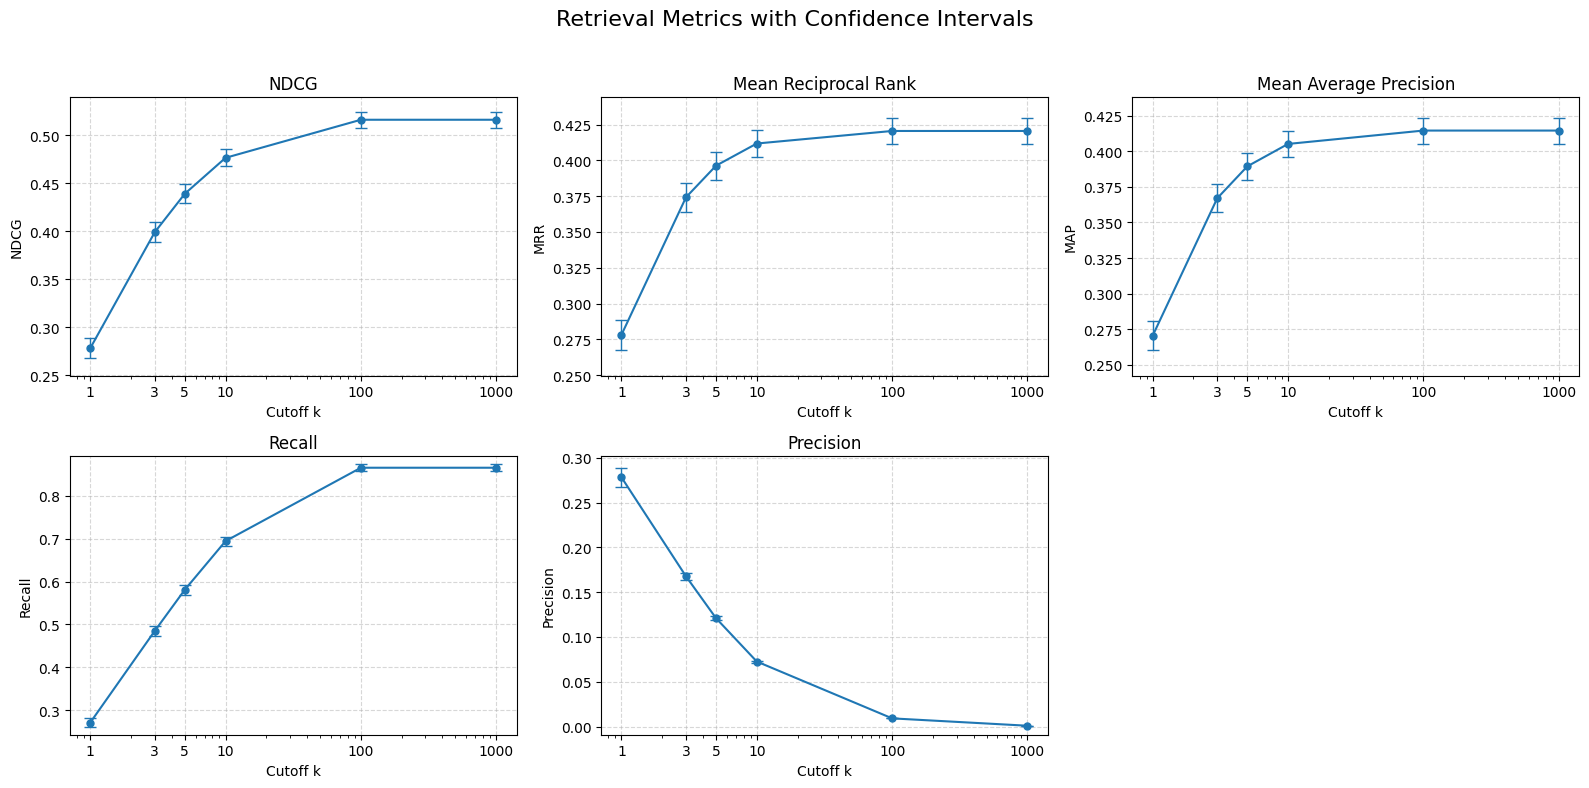

In [66]:
rerank_ndcg, rerank_map, rerank_recall, rerank_precision, rerank_mrr = EvaluateRetrievalCI.evaluate(qrels, rerank_results, k_values=[1, 3, 5, 10, 100, 1000])

plot_all_metrics_with_ci(
    metrics={
        "NDCG": rerank_ndcg,
        "MRR": rerank_mrr,
        "MAP": rerank_map,
        "Recall": rerank_recall,
        "Precision": rerank_precision,
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
)

In [67]:
print(rerank_ndcg, rerank_map, rerank_recall, rerank_precision, rerank_mrr)

{'NDCG@1': {'mean': 0.2782234957020057, 'var': 0.20084395634714208, 'ci': (0.267709743330661, 0.28873724807335044)}, 'NDCG@3': {'mean': 0.3991264868662539, 'var': 0.18595904469600383, 'ci': (0.38900983015591395, 0.40924314357659386)}, 'NDCG@5': {'mean': 0.43909825519741313, 'var': 0.16952018006091615, 'ci': (0.4294391018138992, 0.44875740858092705)}, 'NDCG@10': {'mean': 0.4765221319355256, 'var': 0.14804015603748566, 'ci': (0.4674956581102558, 0.48554860576079545)}, 'NDCG@100': {'mean': 0.5161639353734379, 'var': 0.11904772028294777, 'ci': (0.5080694563550792, 0.5242584143917965)}, 'NDCG@1000': {'mean': 0.5161639353734379, 'var': 0.11904772028294777, 'ci': (0.5080694563550792, 0.5242584143917965)}} {'MAP@1': {'mean': 0.270487106017192, 'var': 0.19377590063135236, 'ci': (0.26016000935442424, 0.28081420267995977)}, 'MAP@3': {'mean': 0.36698901623686725, 'var': 0.17841006043136617, 'ci': (0.3570798291003382, 0.3768982033733963)}, 'MAP@5': {'mean': 0.38935470391595034, 'var': 0.16720800625

### Plotting Evaluation Metrics in common

This block visualizes retrieval performance across different systems using multiple evaluation metrics.
For each metric (NDCG, MRR, MAP, Recall, Precision), scores with confidence intervals are plotted for BM25, sparse (LSR), dense (LDR), fused (RRF), and reranked results.

**Note:** Reranker was limited to top-k 100.

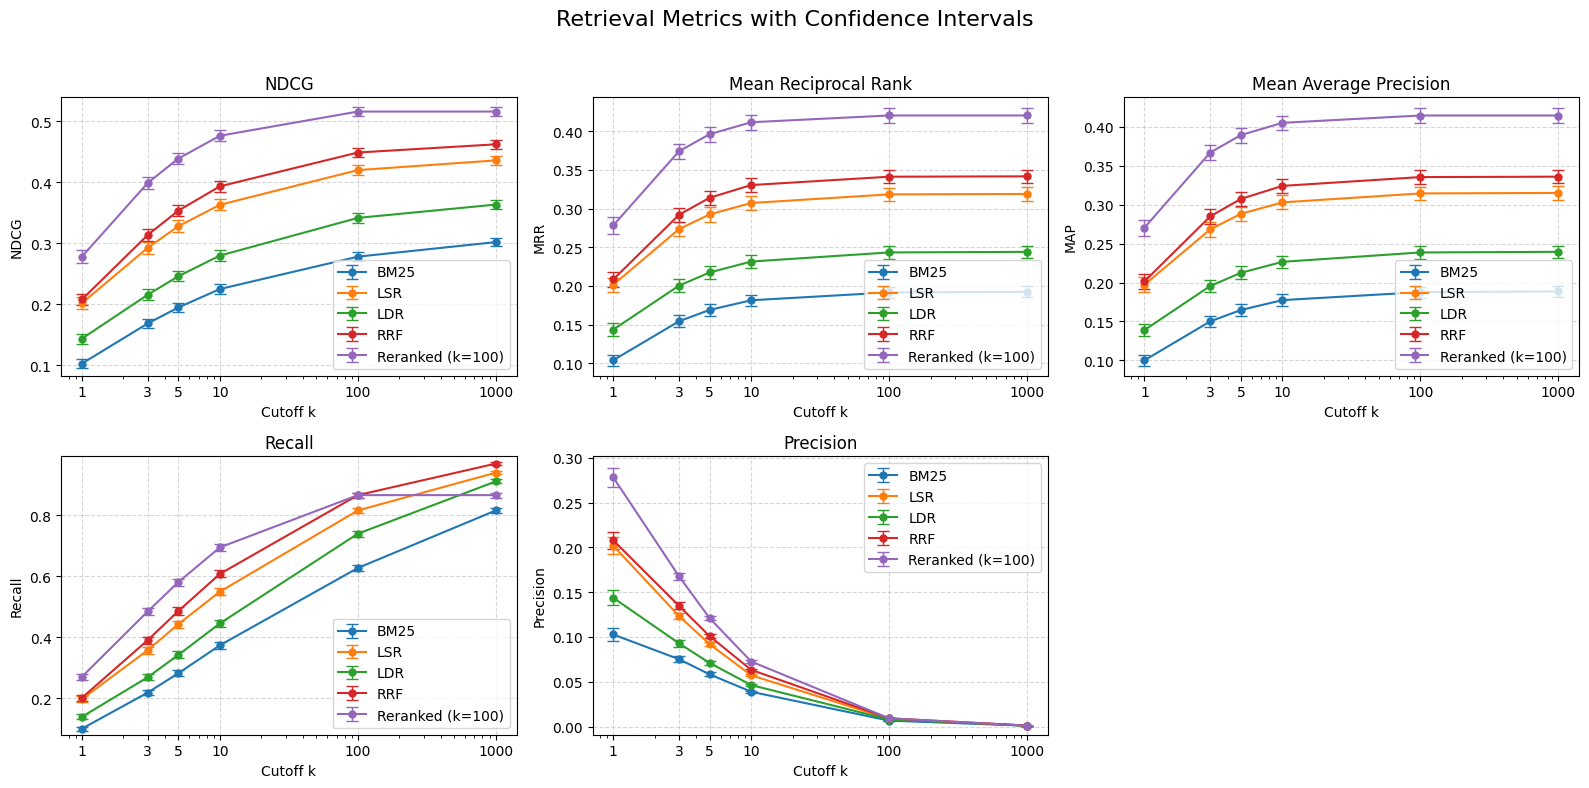

In [68]:
plot_all_metrics_with_ci(
    metrics={
        "NDCG": [bm25_ndcg, lsr_ndcg, ldr_ndcg, fusion_ndcg, rerank_ndcg],
        "MRR": [bm25_mrr, lsr_mrr, ldr_mrr, fusion_mrr, rerank_mrr],
        "MAP": [bm25_map, lsr_map, ldr_map, fusion_map, rerank_map],
        "Recall": [bm25_recall, lsr_recall, ldr_recall, fusion_recall, rerank_recall],
        "Precision": [bm25_precision, lsr_precision, ldr_precision, fusion_precision, rerank_precision],
    },
    titles={
        "NDCG": "NDCG",
        "MRR": "Mean Reciprocal Rank",
        "MAP": "Mean Average Precision",
        "Recall": "Recall",
        "Precision": "Precision",
    },
    ncols=3,
    figsize=(16, 8),
    labels=["BM25", "LSR", "LDR", "RRF", "Reranked (k=100)"],
)

### Inspecting Retrieval Results and Generating an Answer

This block selects a random query and inspects the end-to-end retrieval and reranking behavior for that query.
It maps the query ID back to the original dataset entry, displays the ground-truth relevant documents, and compares them against the top-ranked documents returned by the reranked results.

The top retrieved passages are highlighted, with markers indicating where relevant (gold) documents appear in the ranking. This makes it easy to qualitatively assess retrieval quality, ranking position of relevant documents, and score distributions.

Finally, a causal language model is prompted with the query and the top retrieved passages to generate a concise answer strictly grounded in the retrieved content, or to respond with *“I don’t know”* if the provided passages do not contain sufficient information.

In [45]:
# Get a random query id
# canada query would be "334558"
query_id = np.random.choice(list(rerank_results.keys()))

# Custom function to get mapping from BEIR dataset to MS Marco QA set (keeps your logic)
def get_data_by_query_id(query_id):
    qid = int(query_id)
    rows = [
        (a, b, c, d, e, f, g)
        for a, b, c, d, e, f, g in zip(
            dataset["query_id"].values(),
            dataset["query_id"].keys(),
            dataset["query"].values(),
            dataset["answers"].values(),
            dataset["wellFormedAnswers"].values(),
            dataset["passages"].values(),
            dataset["query_type"].values(),
        )
        if a == qid
    ]
    if not rows:
        raise KeyError(f"query_id={qid} not found in dataset['query_id'].values()")
    return rows[0]

def rank_and_retrieve_docs(corpus, qrels, query_id, results, k=10, scan=1000):
    scores_dict = results[query_id]  # {doc_id: score}
    ranked_doc_ids = sorted(scores_dict, key=scores_dict.get, reverse=True)[:scan]

    top_ids = ranked_doc_ids[:k]
    top_texts = [corpus[doc_id]["text"] for doc_id in top_ids]

    top_scores = list(map(lambda a: scores_dict[a],top_ids))

    gold_ids = set(qrels[query_id].keys())
    gold_positions = [i for i, doc_id in enumerate(ranked_doc_ids) if doc_id in gold_ids]
    try:
        gold_score = list(map(lambda a: scores_dict[a],gold_ids))
    except Exception as e:
        gold_score = 'error'
        #print(e)
        pass

    return top_ids, top_texts, gold_positions, top_scores, gold_score

def shorten(text, width=220):
    text = " ".join(str(text).split())
    return textwrap.shorten(text, width=width, placeholder=" …")

query_id_value, query_id_key, query, answers, wellFormedAnswers, passages, query_type = get_data_by_query_id(query_id=query_id)

print(f"{len(qrels[query_id])} docs in corpus to retrieve for query {queries[query_id]!r}\n")

print("Corpus: " + "#" * 78)
print("Ground Truth - Top 3 most relevant docs:")

top_gold = sorted(qrels[query_id].items(), key=lambda kv: kv[1], reverse=True)[:3]
for rank, (doc_id, rel) in enumerate(top_gold, start=1):
    print(f"{rank:>2}. Key: {doc_id} | rel={rel} | {shorten(corpus[doc_id]['text'])}")

print("#" * 86)
print(f"Expected Answer: {answers}\n")

top_ids, top_texts, gold_positions, top_scores, gold_score = rank_and_retrieve_docs(corpus, qrels, query_id, rerank_results, k=10, scan=1000)
gold_positions_set = set(gold_positions)

for idx, (doc_id, text, score) in enumerate(zip(top_ids, top_texts, top_scores)):
    marker = ">>" if idx in gold_positions_set else "  "
    print(f"{marker} {idx:>2} | {doc_id} | {round(score,4)} | {shorten(text)}")

if gold_positions:
    print(f"\n>>> First gold doc appears at rank {gold_positions[0]} with score {gold_score[0]}. <<<")
else:
    print("\n>>> No gold doc found in the top-1000 ranked list <<<")

model, tokenizer = load_causal_lm("Qwen/Qwen3-0.6B", device_map=None)

result = generate_chat_with_thinking(
    model,
    tokenizer,
    prompt=f"First you have to read and understand the query. Second you have to evaluate the provided content one-by-one. You have to extract information to generate a final answer only by the provided content. If you are confident that nothing can answer the query by the given content, you have to say 'I dont know.', otherwise you have to answer the query by the provided content. QUERY: {query} - CONTENT: {" - ".join(top_texts)}. Answer as short as possible.",
    enable_thinking=True,
    max_new_tokens=1024,
    generation_kwargs={"do_sample": True},
)

# print("thinking content:", result["thinking"])
print("content:", result["content"])

1 docs in corpus to retrieve for query 'mems who is the leader'

Corpus: ##############################################################################
Ground Truth - Top 3 most relevant docs:
 1. Key: 7626797 | rel=1 | The legacy automotive business continues to dominate Boschâs MEMS revenue with 67% in 2014. Bosch is the undisputed leader in automotive MEMS with 30% market shares in 2014 and with revenue more than three times as …
######################################################################################
Expected Answer: ['Bosch is the undisputed leader in automotive MEMS.']

>>  0 | 7626797 | 0.9663 | The legacy automotive business continues to dominate Boschâs MEMS revenue with 67% in 2014. Bosch is the undisputed leader in automotive MEMS with 30% market shares in 2014 and with revenue more than three times as …
    1 | 5131971 | 0.1936 | Find out what makes a great leader, with. James Manktelow & Amy Carlson. Leaders are people who do the right thing; managers are

### Generating a not grounded LLM Answer

This block queries a causal language model directly with a question, without providing retrieved documents or external evidence.
The generated response is based solely on the model’s internal knowledge and generation settings, and is **not grounded** in the retrieval pipeline or source documents.

In [46]:
result = generate_chat_with_thinking(
    model,
    tokenizer,
    prompt="mems who is the leader",
    enable_thinking=True,
    max_new_tokens=1024,
    generation_kwargs={"do_sample": True, "temperature": 0.01, "top_p": 1.0},
)

# print("thinking content:", result["thinking"])
print("content:", result["content"])

content: The term "mems" (Memory, Electronics, and Systems) is not a standard or widely recognized term in the context of organizations or groups. If you meant something else, such as a specific project, company, or technical field, please provide more details so I can assist you better. For example, if you're referring to a specific group or organization, their leadership could be identified through their mission, structure, or other relevant information.


### Grounding Evaluation Example: Canada’s Age

#### Ground Truth Document (Excerpt)

> Canada was finally established as a country in 1867. It is 148 years old as of July 1 2015. Canada has been a country for 147 years. The first attempt at colonization occurred in 1000 A.D. by the Norsemen. There was no …

---

#### Expected Answer

> **Canada is 148 years old as of July 1, 2015.**

---

#### Model Responses Comparison

| Scenario        | Model Answer |
|-----------------|--------------|
| ❌ Not Grounded | Canada’s current age is **136 years** since its independence on **May 16, 1867** |
| ✅ Grounded     | **Canada is 148 years old as of July 1, 2015.** |

---

#### Supporting Evidence  
*(Provided manually for demonstration purposes)*

- **Canada was created (Confederation) on July 1, 1867**, when the **British North America Act**  
  (now the **Constitution Act, 1867**) came into force.
- Key dates:
  - **March 29, 1867** — Royal Assent granted
  - **May 22, 1867** — Royal Proclamation issued
  - **July 1, 1867** — Act came into force (Canada Day)

**Source:**  
https://en.wikipedia.org/wiki/Proclamation_of_the_Constitution_Act%2C_1867

### Batch Grounded Answer Generation and Evaluation

This block performs large-scale grounded question answering using the reranked retrieval results and evaluates the generated answers with both automatic and LLM-based metrics.

For each query, a prompt is constructed that restricts the language model to answer **only** using the top retrieved passages, or to respond with *“I don’t know”* if the content is insufficient. Prompts are generated in advance with progress tracking, and answers are produced in batches using a causal language model (`Qwen3-0.6B`) for efficient GPU utilization.

The generated answers are evaluated against reference answers using standard automatic metrics (BLEU and ROUGE). In addition, an external LLM-based evaluator is used to grade predictions in parallel, providing aggregated qualitative judgments on answer correctness and faithfulness.

In [47]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

In [ ]:
torch.set_float32_matmul_precision("medium")
tokenizer_kwargs = {"padding_side": "left", "truncation_side": "left"}
model_kwargs = {}  # drop if not available

model, tokenizer = load_causal_lm(
    "Qwen/Qwen3-0.6B",
    torch_dtype=torch.bfloat16,
    tokenizer_kwargs=tokenizer_kwargs,
    model_kwargs=model_kwargs,
    device_map=None
)

def build_prompt(query, top_texts):
    return (
        "First you have to read and understand the query. Second you have to evaluate the provided content one-by-one. "
        "You have to extract information to generate a final answer only by the provided content. "
        "If you are confident that nothing can answer the query by the given content, you have to say 'I dont know.', "
        "otherwise you have to answer the query by the provided content. "
        f"QUERY: {query} - CONTENT: {' - '.join([t[:256] for t in top_texts])}. Answer as short as possible."
    )

# Prepare once (with progress)
prepared = []
qid_list = list(rerank_results.keys())
for qid in tqdm(qid_list, desc="Prepare prompts"):
    query_id_value, query_id_key, query, answers, wellFormedAnswers, passages, query_type = get_data_by_query_id(query_id=qid)
    top_ids, top_texts, gold_positions, top_scores, gold_score = rank_and_retrieve_docs(
        corpus, qrels, qid, rerank_results, k=10, scan=10
    )
    prepared.append((query_id_value, query, answers, build_prompt(query, top_texts)))

prompts = [p[3] for p in prepared]
gen_outputs = batch_generate_chat_with_thinking(
    model,
    tokenizer,
    prompts,
    batch_size=180,
    enable_thinking=True,
    generation_kwargs={"do_sample": True, "temperature": 0.01, "top_p": 1.0},
    show_progress=True,
)
pred_texts = [o["content"] for o in gen_outputs]
refs = [". ".join(p[2]) for p in prepared]

# Metrics
bleu_results = bleu_metric.compute(predictions=pred_texts, references=refs)
rouge_results = rouge_metric.compute(predictions=pred_texts, references=refs)

# Parallel OpenAI grading with progress
items = [(q, a, p) for (_, q, a, _), p in zip(prepared, pred_texts)]
eval_results, agg = evaluate_predictions_batch(
    items,
    max_workers=8,
    log_dir="api_responses",
    show_progress=True,
)

print("BLEU:", bleu_results)
print("ROUGE:", rouge_results)
print("OpenAI agg:", agg)

In [70]:
agg_

{'total': 6980,
 'n_correct': 4549,
 'n_miss': 460,
 'n_hallucination': 1971,
 'accuracy': 0.6517191977077363,
 'missing': 0.0659025787965616,
 'hallucination': 0.282378223495702,
 'score': 0.3693409742120344}

In [72]:
rouge_results_

{'rouge1': 0.3058889063971952,
 'rouge2': 0.15848912025182374,
 'rougeL': 0.2712936889177344,
 'rougeLsum': 0.2721616782100187}

In [73]:
bleu_results_

{'bleu': 0.04714313696131765,
 'precisions': [0.12923436423906723,
  0.05437658901053287,
  0.03245311369580945,
  0.021658459697972213],
 'brevity_penalty': 1.0,
 'length_ratio': 3.0456396653744133,
 'translation_length': 373167,
 'reference_length': 122525}

### Computing Per-Example BLEU and ROUGE Scores

This block computes BLEU and ROUGE scores **per query–answer pair** rather than as corpus-level aggregates.
For each generated prediction and its corresponding reference answer, BLEU and multiple ROUGE variants (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum) are calculated individually and stored in separate lists.

In [78]:
bleu_score = []
rouge1_score = []
rouge2_score = []
rougeL_score = []
rougeLS_score = []
for p,r in tqdm(zip(pred_texts_, refs_)):
    bleu_score.append(bleu_metric.compute(predictions=[p], references=[r])['bleu'])
    r = rouge_metric.compute(predictions=[p], references=[r])
    rouge1_score.append(r['rouge1'])
    rouge2_score.append(r['rouge2'])
    rougeL_score.append(r['rougeL'])
    rougeLS_score.append(r['rougeLsum'])

6980it [05:34, 20.88it/s]


### Analyzing LLM Evaluation Outcomes and Correlations

This block analyzes the outcomes of the LLM-based evaluation by categorizing predictions into **correct**, **missed**, and **hallucinated** cases based on the evaluator’s judgments (`is_correct`, `is_missing`).

It computes summary statistics such as accuracy, missing rate, and hallucination rate, providing an interpretable breakdown of model behavior beyond aggregate scores.

Finally, a correlation heatmap is plotted to examine relationships between evaluation outcomes (correct, missed, hallucinated) and automatic metrics (BLEU and ROUGE). This visualization highlights how well traditional n-gram–based metrics align with qualitative correctness and hallucination signals.

Correct predictions:      4549
Accuracy:                 0.6517191977077363
Missed predictions:       460
Missing Rate:             0.0659025787965616
Hallucinated predictions: 1971
Hallucination Rate:       0.282378223495702


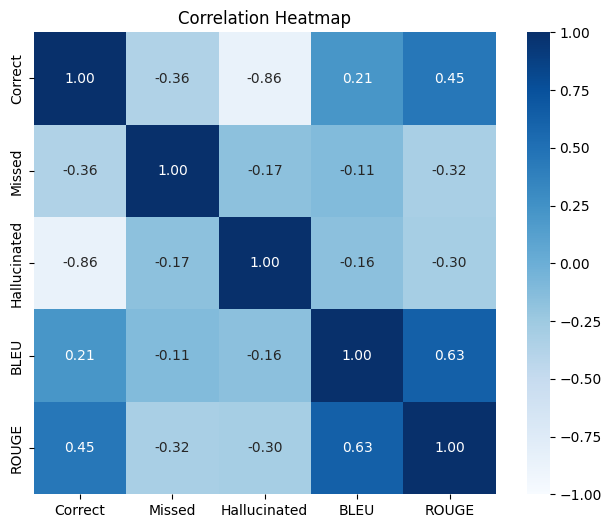

In [79]:
# OAI Evaluater => (Is correct, Is missing)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Correct predictions (true, false)
correct_pred = [1 if v1 and not v2 else 0 for idx,(v1,v2) in enumerate(eval_results_)] # (Is correct and is not missing)
print(f"Correct predictions:      {Counter(correct_pred)[1]}")
print(f"Accuracy:                 {Counter(correct_pred)[1]/len(eval_results_)}")

# Missed predictions (true/false, true)
missed_pred = [1 if not v1 and v2 else 0 for idx,(v1,v2) in enumerate(eval_results_)]  # (Is not correct and is missing)
print(f"Missed predictions:       {Counter(missed_pred)[1]}") 
print(f"Missing Rate:             {Counter(missed_pred)[1]/len(eval_results_)}")

# Hallucinated predictions (false, false)
hallucinated_pred = [1 if not v1 and not v2 else 0 for idx,(v1,v2) in enumerate(eval_results_)]  # (Is not correct and is not missing) => is made up
print(f"Hallucinated predictions: {Counter(hallucinated_pred)[1]}")
print(f"Hallucination Rate:       {Counter(hallucinated_pred)[1]/len(eval_results_)}")


plt.figure(figsize=(8,6))
corr = np.corrcoef([correct_pred,missed_pred,hallucinated_pred], [bleu_score, rouge1_score])
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    xticklabels=["Correct", "Missed", "Hallucinated", "BLEU", "ROUGE"],
    yticklabels=["Correct", "Missed", "Hallucinated", "BLEU", "ROUGE"],
    vmin=-1, vmax=1,
    square=True,
    cmap="Blues"
)
plt.title("Correlation Heatmap")
plt.show()

### Evaluating Metric Discriminative Power with Oriented AUC

This block measures how well automatic metrics (BLEU and ROUGE) discriminate between different outcome categories—**correct**, **missed**, and **hallucinated** predictions—using ROC AUC.

For each category, a binary label vector is compared against metric scores to compute the standard ROC AUC. Since higher metric values may correlate either positively or negatively with a given outcome, an *oriented AUC* is also reported, defined as `max(AUC, 1 − AUC)`.

These results quantify how informative BLEU and ROUGE are for detecting correctness, missing answers, and hallucinations in grounded generation settings.

In [80]:
def oriented_auc(y, score):
    auc = roc_auc_score(y, score)
    return auc, max(auc, 1-auc)

for name, y in [("Correct", correct_pred), ("Missed", missed_pred), ("Hallucinated", hallucinated_pred)]:
    auc_r, o_r = oriented_auc(y, rouge1_score)
    auc_b, o_b = oriented_auc(y, bleu_score)
    print(name, "ROUGE:", auc_r, "oriented:", o_r, "| BLEU:", auc_b, "oriented:", o_b)


Correct ROUGE: 0.8006310281600261 oriented: 0.8006310281600261 | BLEU: 0.5951613849794445 oriented: 0.5951613849794445
Missed ROUGE: 0.045728360896239016 oriented: 0.954271639103761 | BLEU: 0.35773339557215256 oriented: 0.6422666044278474
Hallucinated ROUGE: 0.30125955927731907 oriented: 0.6987404407226809 | BLEU: 0.436626755756432 oriented: 0.5633732442435679


### Threshold Selection and Classification Analysis Using ROUGE

This block derives an optimal decision threshold on ROUGE scores to classify predictions as **correct** or **incorrect**.
The ROC curve is computed using correctness labels and ROUGE-1 scores, and the threshold is selected by maximizing Youden’s J statistic (`TPR − FPR`), which balances sensitivity and specificity.

Using this threshold, predictions are binarized and evaluated with a confusion matrix and a detailed classification report (precision, recall, F1-score). This analysis illustrates how an automatic metric can be converted into a decision rule and how well it aligns with LLM-based correctness judgments.

In [81]:
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

y = np.array(correct_pred, dtype=int)
s = np.array(rouge1_score, dtype=float)

fpr, tpr, thr = roc_curve(y, s)
j = tpr - fpr
best_thr = thr[np.argmax(j)]

y_hat = (s >= best_thr).astype(int)

print("Best threshold:", best_thr)
print("Confusion matrix [[TN FP],[FN TP]]:\n", confusion_matrix(y, y_hat))
print(classification_report(y, y_hat, digits=3))


Best threshold: 0.20779220779220778
Confusion matrix [[TN FP],[FN TP]]:
 [[1715  716]
 [1074 3475]]
              precision    recall  f1-score   support

           0      0.615     0.705     0.657      2431
           1      0.829     0.764     0.795      4549

    accuracy                          0.744      6980
   macro avg      0.722     0.735     0.726      6980
weighted avg      0.755     0.744     0.747      6980



Using ROUGE-1 with a threshold of ~0.208, we identify 76.4% of correct samples as correct (and miss 23.6%). When ROUGE-1 predicts correct, it’s correct 82.9% of the time.

### Releasing GPU Memory

This utility block frees unused GPU memory during long-running experiments.
It triggers Python garbage collection and clears PyTorch’s CUDA cache and IPC handles, helping reduce memory fragmentation and prevent out-of-memory errors between model runs or evaluation stages.

In [82]:
def flush_cuda():
    # Run Python garbage collection
    gc.collect()

    # Clear PyTorch CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

# Usage
flush_cuda()
